In [1]:
# check the cars that have a disabled parking permit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import sys
#sys.path.append('/Users/dpelleg/miniconda/lib/python3.10/site-packages')

from statsmodels.stats.proportion import proportions_ztest

# do I need this? how to persist the change in path?


In [2]:
datadir = '../data/'

def count_repeated_chars(string, k):
    count = 0
    for i in range(len(string)-(k-1)):
        if string[i:i+k] == string[i]*k:
            count += 1
    return count

def is_palindrome(string):
    return string == string[::-1]

def has_numeric_sequence_3(string):
    for i in range(len(string)-2):
        if int(string[i])+1 == int(string[i+1]) and int(string[i+1])+1 == int(string[i+2]):
            return True
    return False

def has_numeric_sequence_3_rev(string):
    return has_numeric_sequence_3(string[::-1])

def count_distinct_chars(string):
    return len(set(string))

def distinct_chars_under(s, n):
    return count_distinct_chars(s) <= n

def distinct_chars_over(s, n):
    return count_distinct_chars(s) >= n

def count_repeated_sequences(string, seq_length):
    count = 0
    for i in range(len(string) - seq_length + 1):
        if string[i:i+seq_length] in string[i+seq_length:]:
            count += 1
    return count

scoremap = {
    lambda s: count_repeated_chars(s, 2): 1,
    lambda s: count_repeated_chars(s, 3): 1,
    lambda s: count_repeated_chars(s, 4): 1,
    is_palindrome: 5,
    has_numeric_sequence_3 : 2,
    has_numeric_sequence_3_rev : 2,
    lambda s: distinct_chars_under(s, 1): 10,
    lambda s: distinct_chars_under(s, 2): 5,
    lambda s: distinct_chars_under(s, 3): 2,
#    lambda s: distinct_chars_over(s, 5): 2,
#    lambda s: distinct_chars_over(s, 6): 5,
#    lambda s: distinct_chars_over(s, 7): 6,
#    lambda s: distinct_chars_over(s, 8): 8,
    lambda s: count_repeated_sequences(s, 2): 2,
    lambda s: count_repeated_sequences(s, 3): 3,
}

def score(s):
    ret = 0
    for idx, (f, mult) in enumerate(scoremap.items()):
        result = f(s)
        ret += mult*int(result)
    return ret

In [3]:
def read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur', 'sug_degem']]), axis=1)

def get_model_name(ns):
    names = pd.DataFrame(data={'model':ns})
    ret = pd.merge(names, models, how='left', on='model')[['tozeret_nm', 'kinuy_mishari']]
    return ret

def ztest_proportions(df, population, test):
    xtab=pd.crosstab(df[population], df[test])
    se, pval = proportions_ztest(xtab[True].to_list(), xtab.sum(axis=1).to_list())
    return pval

In [5]:
# source : https://data.gov.il/dataset/private-and-commercial-vehicles/
#   (if it doesn't download fully, try with Chrome)

#df = pd.read_csv('data/rechev-small.csv', encoding='iso-8859-1', sep='|')
cars = read_file(datadir + 'rechev.csv')

for c in ['mispar_rechev', 'degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    cars[c] = cars[c].astype(str)

add_model(cars)

cars['score'] = cars['mispar_rechev'].apply(score)

In [6]:
# source: https://data.gov.il/dataset/rechev-tag-nachim
disabled = pd.read_csv(datadir + 'disabled-plates.csv', sep='|')
disabled.columns = ['mispar_rechev', 'taarich_tag', 'sug_tag']
for c in ['mispar_rechev']:
    disabled[c] = disabled[c].astype(str)
#disabled['score'] = disabled['mispar_rechev'].apply(score)

In [7]:
# merge dataframes
merged = pd.merge(cars, disabled, on='mispar_rechev', how='left', indicator=True)

# create boolean column indicating if record exists in Y
merged['disabled'] = merged['_merge'] == 'both'
merged.drop(columns=['_merge'], inplace=True)
# there are about 14,000 records which are only in the disabled set, not much to do about them

df = merged

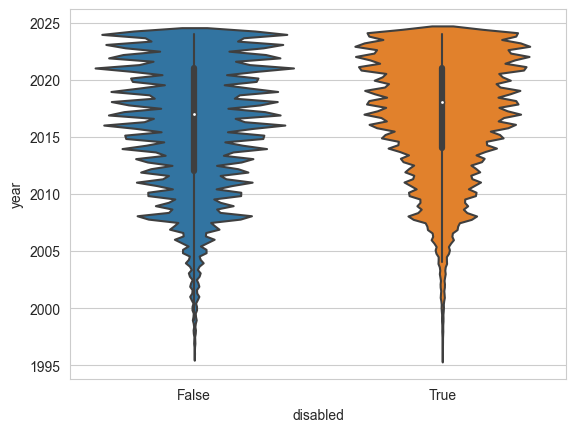

In [8]:
df['year'] = pd.to_numeric(df['shnat_yitzur'], errors='ignore')
sns.violinplot(x='disabled', y='year', data=df)

plt.show()

In [11]:
# source : https://data.gov.il/dataset/mehir_yevuan
# add model prices
fname = datadir + 'vehicle_cost.csv'
fd = open(fname, encoding='utf-8', errors='replace')
prices = pd.read_csv(fd, sep='|', low_memory=False)

for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    prices[c] = prices[c].astype(str)
for c in ['mehir']:
    prices[c] = pd.to_numeric(prices[c], errors='coerce')

add_model(prices)
prices_ = prices.copy()
prices = prices[['model', 'mehir']]
df = pd.merge(left=df, right=prices, on='model')

In [12]:
cols =['ramat_eivzur_betihuty', 'kvutzat_zihum', 'score', 'year', 'mehir']
df.groupby('disabled')[cols].agg(['mean', 'count'])

ramat_eivzur_betihuty          kvutzat_zihum              score  \
                          mean    count          mean    count      mean   
disabled                                                                   
False                 3.176190  1211588     11.751573  2819345  1.099685   
True                  3.282546   291075     11.738049   586580  1.144578   

                          year                   mehir           
            count         mean    count           mean    count  
disabled                                                         
False     3162437  2016.228120  3162437  154730.834028  3162437  
True       646646  2017.096133   646646  166882.183618   646646

In [13]:
#sns.violinplot(x='disabled', y='mehir', data=df.query('mehir < 4e5'))
#plt.show()

In [37]:
# read detailed tech specs on each model
# source: https://data.gov.il/dataset/degem-rechev-wltp
models = read_file(datadir + 'models.csv', enc='utf-8')
#models.columns
cols = ['tozeret_cd', 'tozeret_nm', 'shnat_yitzur',
       'degem_cd', 'nefah_manoa',
       'mishkal_kolel', 'gova',
       'hege_koah_ind',
       'automatic_ind',
       'koah_sus',
       'mispar_moshavim', 'kinuy_mishari', 'sug_degem',
       'hanaa_nm', 'merkav'
       ]
models = models[cols]
for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    models[c] = models[c].astype(str)

add_model(models)
df_before = df.copy()
merged = pd.merge(left=df_before, right=models.drop(columns=['kinuy_mishari', 'sug_degem', 'tozeret_nm']), on='model', how='left', indicator=True)
merged.drop(columns=['_merge'], inplace=True)
df=merged

FileNotFoundError: [Errno 2] No such file or directory: '../data/models.csv'

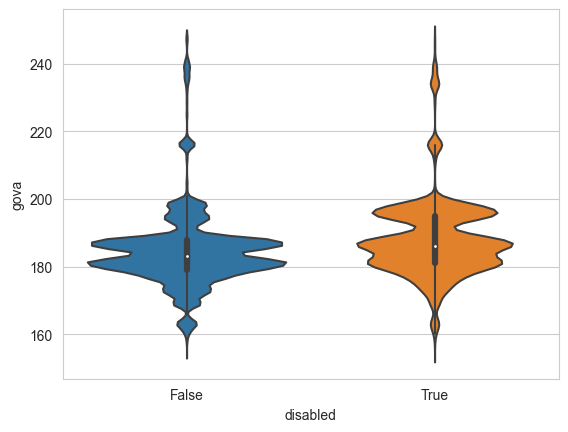

In [20]:
sns.violinplot(x='disabled', y='gova', data=merged.query('gova > 150 and gova < 250'))
#plt.legend(title="הכנ", labels=["No", "Yes"])
plt.show()

In [21]:
df['mehir'].quantile(0.9)

229990.0

In [22]:
df['koah_sus'].quantile(0.95)

204.0

In [36]:
# check proportions of news cars with disabled permits
df['new'] = df['year'] > 2021
df['newest'] = df['year'] > 2023

# check proportions of luxury cars with disabled permits
df['luxury'] = df['mehir'] > df['mehir'].quantile(0.9)

# check proportions of fancy-plate cars with disabled permits
df['coolnum'] = df['score'] > df['score'].quantile(0.9)

# check proportions of tall cars with disabled permits
df['tall'] = df['gova'] > 220

# check proportions of short cars with disabled permits
df['short'] = (df['gova'] < 160) & (df['gova'] > 0)

# check proportions of muscle cars with disabled permits
df['muscle'] = df['koah_sus'] > df['koah_sus'].quantile(0.95)

# Tesla
df['tesla'] = df['tozeret_nm'].str.contains("טסלה")

# people-mover
df['seven'] = df['mispar_moshavim'] >= 7

# huge pickup type
df.loc[:, 'monster'] = df.eval('gova > 180 and hanaa_nm == "4X4" and nefah_manoa > 2000 and mispar_moshavim < 7')

# chassis type fits a people-mover
mask_merkavim = ["סגור/משלוח", "משא אחוד", "ואן/נוסעים", "קומבי"]
mask_merkavim.append("MPV")
df['ppl_mover'] = df['merkav'].isin(mask_merkavim)


# more features
features = ['automatic_ind', 'hege_koah_ind']
for c in features:
    df[c] = df[c] == 1

features = ['new', 'newest', 'luxury', 'coolnum', 'tall', 'short', 'muscle', 'tesla', 'seven', 'monster', 'ppl_mover'] + features
for f in features:
    pv = ztest_proportions(df, 'disabled', f)
    print(f'Testing {f}, p-val:{pv:.3f}')
    print(pd.crosstab(df['disabled'], df[f], normalize='index'))
    print(pd.crosstab(df['disabled'], df[f]))
    print('-----')

Testing new, p-val:0.000
new          False     True 
disabled                    
False     0.794290  0.205710
True      0.762952  0.237048
new         False   True 
disabled                 
False     2511893  650544
True       493360  153286
-----
Testing newest, p-val:0.000
newest       False     True 
disabled                    
False     0.930442  0.069558
True      0.925443  0.074557
newest      False   True 
disabled                 
False     2942464  219973
True       598434   48212
-----
Testing luxury, p-val:0.000
luxury       False     True 
disabled                    
False     0.905438  0.094562
True      0.874403  0.125597
luxury      False   True 
disabled                 
False     2863392  299045
True       565429   81217
-----
Testing coolnum, p-val:0.000
coolnum      False     True 
disabled                    
False     0.953841  0.046159
True      0.948766  0.051234
coolnum     False   True 
disabled                 
False     3016463  145974
True       613516 

In [24]:
for f in features:
    print('example of cars of type:' + f)
    ns=list(df.query(f)['model'].value_counts().index[:20])
    print(get_model_name(ns).drop_duplicates())

example of cars of type:new
       tozeret_nm    kinuy_mishari
0       בי ווי די           ATTO 3
1   יונדאי קוריאה     IONIQ HYBRID
2      קיה קוריאה          PICANTO
3   טויוטה טורקיה  COROLLA HSD SDN
5     מזדה תאילנד          MAZDA 2
6   יונדאי קוריאה      ELANTRA HEV
7      קיה קוריאה   NIRO PLUS PHEV
9        צ'רי סין      TIGGO 8 PRO
10        מ.ג סין         EHS PHEV
13    סקודה צ'כיה          OCTAVIA
14    טויוטה צרפת  YARIS CROSS HSD
17  יונדאי טורקיה              I20
19       גילי סין       GEOMETRY C
example of cars of type:newest
        tozeret_nm    kinuy_mishari
0        בי ווי די           ATTO 3
2    יונדאי קוריאה      ELANTRA HEV
3       קיה קוריאה   NIRO PLUS PHEV
5         צ'רי סין      TIGGO 8 PRO
6      מזדה תאילנד          MAZDA 2
7      סקודה צ'כיה          OCTAVIA
8      טויוטה צרפת  YARIS CROSS HSD
9       קיה קוריאה          PICANTO
10        גילי סין       GEOMETRY C
12   טויוטה טורקיה  COROLLA SDN HSD
14  סוזוקי הונגריה          S-CROSS
15       בי ווי די 

In [25]:
for f in ['muscle', 'seven']:
    for b in ['', ' not ']:
        fb = f'{f} and {b} disabled'
        print('example of cars of type:' + fb)
        ns=list(df.query(fb)['model'].value_counts().index[:10])
        print(get_model_name(ns).drop_duplicates())

example of cars of type:muscle and  disabled
      tozeret_nm kinuy_mishari
0     ג'ילי זיקר       ZEEKR X
1     אקספנג סין            G6
2        סרס סין         SERES
3  יונדאי קוריאה        IONIQ5
5       טסלה סין       MODEL 3
9     קיה קוריאה      CARNIVAL
example of cars of type:muscle and  not  disabled
      tozeret_nm kinuy_mishari
0     ג'ילי זיקר       ZEEKR X
1     אקספנג סין            G6
2       טסלה סין       MODEL 3
3  יונדאי קוריאה        IONIQ5
4        סרס סין         SERES
example of cars of type:seven and  disabled
     tozeret_nm kinuy_mishari
0      צ'רי סין   TIGGO 8 PRO
1  מיצובישי יפן     OUTLANDER
8  מיצובישי יפן       GRANDIS
example of cars of type:seven and  not  disabled
     tozeret_nm kinuy_mishari
0      צ'רי סין   TIGGO 8 PRO
1  מיצובישי יפן     OUTLANDER
6      מזדה יפן       MAZDA 5
7  מיצובישי יפן       GRANDIS


In [26]:
# check if vans are more likely to be new-ish
# the social security funds replacement of vans every 5 years for the disabled
df['year'] = df['shnat_yitzur_x'].astype(int)
pm = df.query('ppl_mover')
pm.loc[:, 'new'] = pm['year'] > 2018

for f in ['new', 'tall']:
    pv = ztest_proportions(pm, 'disabled', f)
    print(f'Testing {f}, p-val:{pv:.3f}')
    print(pd.crosstab(pm['disabled'], pm[f], normalize='index'))
    print(pd.crosstab(pm['disabled'], pm[f]))
    print('-----')

Testing new, p-val:0.000
new          False     True 
disabled                    
False     0.633737  0.366263
True      0.472706  0.527294
new        False  True 
disabled               
False     104097  60162
True       17934  20005
-----
Testing tall, p-val:0.000
tall         False     True 
disabled                    
False     0.977286  0.022714
True      0.983632  0.016368
tall       False  True 
disabled               
False     160528   3731
True       37318    621
-----


/var/folders/l5/kkx8dwdn57s3v0k59p9m7sv80007gv/T/ipykernel_99914/3931476907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm.loc[:, 'new'] = pm['year'] > 2018


In [27]:
ns=list(df.query('muscle and disabled')['model'].value_counts().index[:20])
print(get_model_name(ns).drop_duplicates())

       tozeret_nm   kinuy_mishari
0      ג'ילי זיקר         ZEEKR X
1      אקספנג סין              G6
2         סרס סין           SERES
3   יונדאי קוריאה          IONIQ5
5        טסלה סין         MODEL 3
9      קיה קוריאה        CARNIVAL
12        מ.ג סין             MG4
15    קיה סלובקיה        SPORTAGE
16     ג'יפ ארהב"  GRAND CHEROKEE


In [28]:
print(df['mehir'].median())
C='model'
value_counts = df[C].value_counts()
mask = (df[C].map(value_counts) > 50)

bymodel=df.loc[mask].groupby(C)['disabled'].mean().sort_values()
bymodel_ = bymodel.copy()

bymodel=bymodel_.reset_index()
bymodel.columns=['model', 'disabled_prop']

bymodel=pd.merge(bymodel, prices, on='model')

bymodel = pd.merge(bymodel, models, how='left', on='model')[['disabled_prop', 'tozeret_nm', 'kinuy_mishari', 'mehir', 'merkav']]

mask_merkavim = ["סגור/משלוח", "משא אחוד", "ואן/נוסעים", "קומבי"]
mask_merkavim.append("MPV")
bymodel['ppl_mover'] = bymodel['merkav'].isin(mask_merkavim)

135900.0


In [29]:
bymodel.sort_values(by='disabled_prop')[-20:].drop_duplicates()

,disabled_prop,tozeret_nm,kinuy_mishari,mehir,merkav,ppl_mover
9968,0.897959,רנו צרפת,TRAFIC,253990.0,קומבי,True
9969,0.900000,פולקסווגן גרמנ,CARAVELLE,294000.0,ואן/נוסעים,True
9970,0.903448,מרצדס בנץ ספרד,VITO,274950.0,קומבי,True
9971,0.905405,יונדאי קוריאה,STARIA,279900.0,קומבי,True
9972,0.905830,רנו צרפת,TRAFIC,261990.0,קומבי,True
9973,0.907563,פולקסווגן גרמנ,CARAVELLE,284000.0,ואן/נוסעים,True
9974,0.918033,רנו צרפת,TRAFIC,261990.0,קומבי,True
9975,0.920000,פולקסווגן גרמנ,CARAVELLE,294000.0,ואן/נוסעים,True
9976,0.923077,פולקסווגן גרמנ,CARAVELLE,304000.0,ואן/נוסעים,True
9977,0.923913,פולקסווגן פולי,CADDY,197900.0,קומבי,True


In [30]:
merkavim = df['merkav'].unique()
for m in merkavim:
    f = f'merkav == "{m}"'
    print('example of cars of type:' + f)
    ns=list(df.query(f)['model'].value_counts().index[:10])
    print(get_model_name(ns).drop_duplicates())   

example of cars of type:merkav == "פנאי-שטח"
     tozeret_nm    kinuy_mishari
0     בי ווי די           ATTO 3
2   קיה סלובקיה         SPORTAGE
5      צ'רי סין      TIGGO 8 PRO
6   טויוטה צרפת  YARIS CROSS HSD
7      גילי סין       GEOMETRY C
8  מיצובישי יפן        OUTLANDER
example of cars of type:merkav == "MPV"
      tozeret_nm   kinuy_mishari
0   מיצובישי יפן       OUTLANDER
1   מיצובישי יפן         GRANDIS
2   סיטרואן ספרד  C4 SPACETOURER
5  טויוטה טורקיה           VERSO
9   מיצובישי יפן             ASX
example of cars of type:merkav == "סדאן"
      tozeret_nm    kinuy_mishari
0       מזדה יפן          MAZDA 3
2     טויוטה יפן          COROLLA
3  טויוטה טורקיה          COROLLA
4  טויוטה טורקיה  COROLLA HSD SDN
9  יונדאי קוריאה      ELANTRA HEV
example of cars of type:merkav == "הצ'בק"
      tozeret_nm kinuy_mishari
0  יונדאי קוריאה  IONIQ HYBRID
1     קיה קוריאה       PICANTO
5    מזדה תאילנד       MAZDA 2
6    דייהטסו-יפן       .SIRION
7  יונדאי טורקיה           I10
9        מ.ג 

In [31]:
mask_merkavim = ["סגור/משלוח", "משא אחוד", "ואן/נוסעים", "קומבי"]
mask_merkavim.append("MPV")
bymodel['ppl_mover'] = bymodel['merkav'].isin(mask_merkavim)

<Axes: xlabel='disabled_prop', ylabel='mehir'>

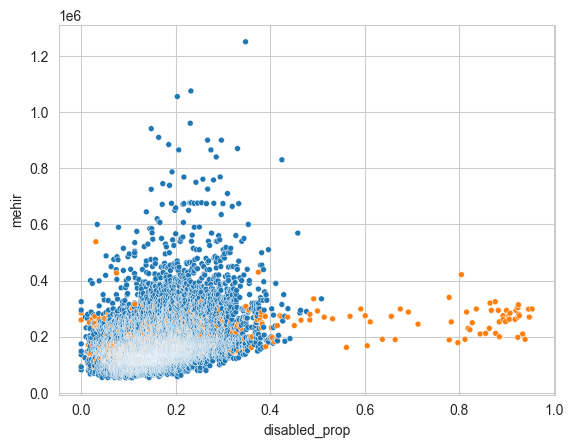

In [32]:
sns.scatterplot(data=bymodel, x='disabled_prop', y='mehir', size=3, legend=False, hue=bymodel['ppl_mover'])

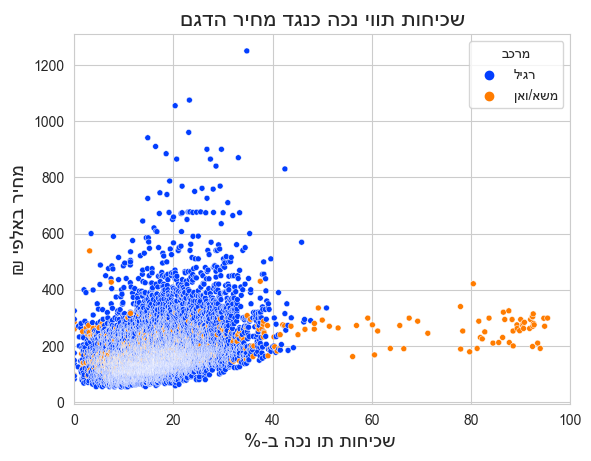

In [33]:
def rev(s):
    return s[::-1]

# Customize the plot style and aesthetics
sns.set_style("whitegrid")
sns.set_palette("bright")

#custom_palette = {"foo": sns.color_palette()[0], "bar": sns.color_palette()[1]}

bymodel['d_p'] = 100*bymodel['disabled_prop']
bymodel['mk'] = bymodel['mehir']/1000
#bymodel['ppl_mover'] = bymodel['ppl_mover'].astype(int)

ax = sns.scatterplot(data=bymodel, x='d_p', y='mk', size=4, hue=bymodel['ppl_mover'])

fs=14
plt.title(rev("שכיחות תווי נכה כנגד מחיר הדגם"), fontsize=fs+2)
plt.xlabel(rev(" שכיחות תו נכה ב-%"), fontsize=fs)
plt.ylabel(rev("מחיר באלפי ₪"), fontsize=fs)

plt.ticklabel_format(style='plain', axis='y')
plt.xlim(0, 100)

handles, labels = ax.get_legend_handles_labels()
handles = handles[:-1]
labels = labels[:-1]
ax.legend(title=rev("מרכב"), labels=[rev("רגיל"), rev("משא/ואן")], handles=handles)


In [34]:
models_ = read_file(datadir + 'models.csv', enc='utf-8')

In [35]:
models_.query('gova > 200 and hanaa_nm == "4X4" and nefah_manoa > 2000 and mispar_moshavim < 7')[['tozeret_nm','kinuy_mishari', 'mispar_moshavim']].drop_duplicates()

,tozeret_nm,kinuy_mishari,mispar_moshavim
147,דימלרקריזלר-גר,313 CDI,6
1020,גיפ-ישראל,סופה,4
2351,טויוטה יפן,לנד קרוזר_ארוך,0
3760,מרצדס בנץ גרמנ,SPRINTER,3
3794,מרצדס בנץ גרמנ,SPRINTER,2
5372,פולקסווגן גרמנ,TRANSPORTER,3
5396,פולקסווגן גרמנ,TRANSPORTER,2
5551,פולקסווגן גרמנ,TRNSPORTER,3
7139,פולקסווגן גרמנ,LT,1
7201,"פורד ארהב""",F 150,5
